# Fine-tunning du modèle tiny deit pour le dataset PCAM d'images tumorales

In [3]:
# !pip install --quiet torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import time
import zipfile
import os
import cv2
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torch.utils.data import TensorDataset, DataLoader


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


#I. Chargement du modèle tiny deit et adaptation à la classification tumorale

In [3]:
## Charger et modifier le modèle Deit pré-entraîné
model_deit = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)

# Modifier la dernière couche pour avoir 2 sorties (tumeur vs non-tumeur)
in_features = model_deit.head.in_features
model_deit.head = nn.Linear(in_features, 2)

# Vérifier la nouvelle architecture
print(model_deit)



Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/root/.cache/torch/hub/facebookresearch_deit_main/models.py:62: UserWarning: Overwriting deit_tiny_patch16_224 in registry with models.deit_tiny_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/root/.cache/torch/hub/facebookresearch_deit_main/models.py:77:

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()


# Génération du dataset COVID-QU-Ex et transformation des inputs pour l'adapter à Deit (224px*224px)

In [6]:
!pip install kaggle
!kaggle datasets download -d anasmohammedtahir/covidqu



Dataset URL: https://www.kaggle.com/datasets/anasmohammedtahir/covidqu
License(s): CC-BY-SA-4.0
100%|█████████████████████████████████████▊| 1.15G/1.15G [00:31<00:00, 45.2MB/s]
100%|██████████████████████████████████████| 1.15G/1.15G [00:31<00:00, 39.5MB/s]


In [7]:
with zipfile.ZipFile('covidqu.zip', 'r') as zip_ref:
    zip_ref.extractall('covidqu')


In [ ]:
def print_directory_tree_dirs(root, indent=""):
    print(indent + os.path.basename(root) + "/")
    # On ne parcourt que les sous-dossiers
    for item in sorted(os.listdir(root)):
        path = os.path.join(root, item)
        if os.path.isdir(path):
            print_directory_tree_dirs(path, indent + "    ")

# Remplacez par le chemin de votre dataset, par exemple "/content/covidqu"
dataset_root = "covidqu"
print_directory_tree_dirs(dataset_root)



covidqu/
    Infection Segmentation Data/
        Infection Segmentation Data/
            Test/
                COVID-19/
                    images/
                    infection masks/
                    lung masks/
                Non-COVID/
                    images/
                    infection masks/
                    lung masks/
                Normal/
                    images/
                    infection masks/
                    lung masks/
            Train/
                COVID-19/
                    images/
                    infection masks/
                    lung masks/
                Non-COVID/
                    images/
                    infection masks/
                    lung masks/
                Normal/
                    images/
                    infection masks/
                    lung masks/
            Val/
                COVID-19/
                    images/
                    infection masks/
                    lung masks/
        

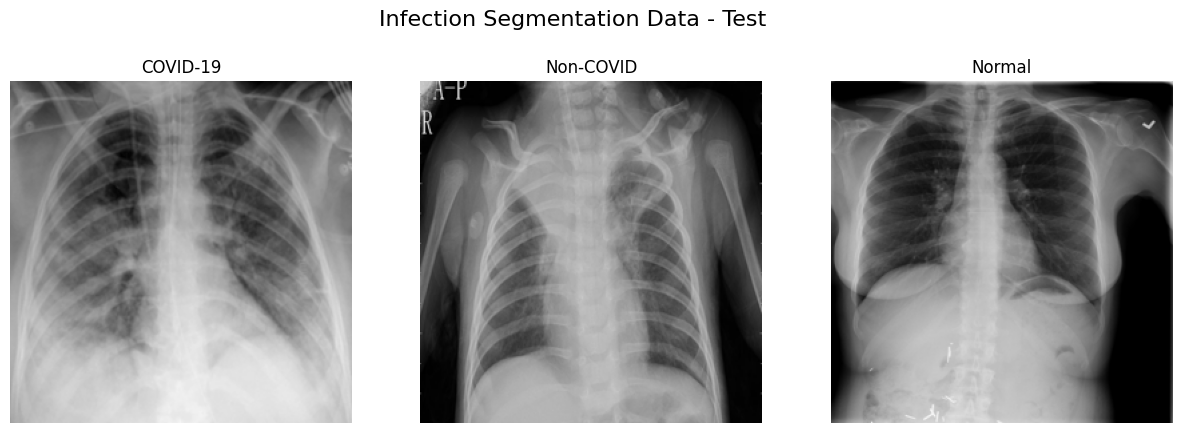

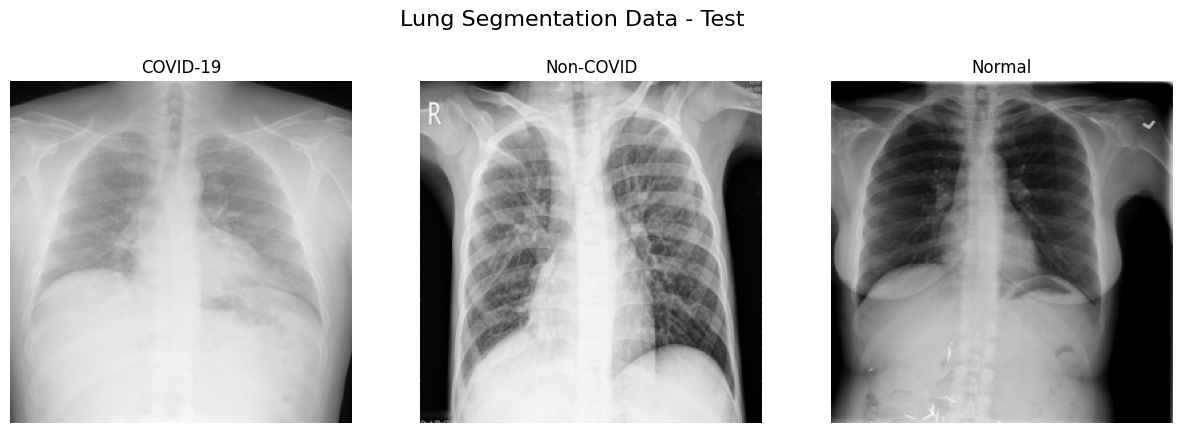

In [7]:
def display_samples(root, segmentation_type, mode):
    """
    Affiche la première image de chaque catégorie pour le split donné.

    Args:
        root (str): Chemin racine du dataset (ex: "/content/covidqu")
        segmentation_type (str): "Infection Segmentation Data" ou "Lung Segmentation Data"
        mode (str): "Train", "Val" ou "Test" (avec la première lettre en majuscule)
    """
    # Chemin vers le dossier du split, par exemple :
    # /content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test
    split_dir = os.path.join(root, segmentation_type, segmentation_type, mode)
    # Liste des classes (Normal, COVID-19, Non-COVID)
    classes = sorted(os.listdir(split_dir))

    # Préparation de l'affichage
    plt.figure(figsize=(15,5))
    for i, cls in enumerate(classes):
        cls_path = os.path.join(split_dir, cls, "images")
        if not os.path.isdir(cls_path):
            continue
        # Récupère la première image (selon l'ordre alphabétique)
        img_files = sorted(os.listdir(cls_path))
        if len(img_files) == 0:
            continue
        img_path = os.path.join(cls_path, img_files[0])
        # Chargement et conversion de l'image (BGR -> RGB)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Affichage de l'image
        plt.subplot(1, len(classes), i+1)
        plt.imshow(img)
        plt.title(f"{cls}")
        plt.axis("off")
    plt.suptitle(f"{segmentation_type} - {mode}", fontsize=16)
    plt.show()

# Exemple d'utilisation :
dataset_root = "/content/covidqu"

# Affichage pour le type "Infection Segmentation Data" dans le split "Test"
display_samples(dataset_root, "Infection Segmentation Data", "Test")

# Vous pouvez aussi afficher pour le type "Lung Segmentation Data" de la même façon :
display_samples(dataset_root, "Lung Segmentation Data", "Test")


In [8]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

class InfectionBinaryDataset(Dataset):
    def __init__(self, rootpath, mode='Train', cropsize=(224,224)):
        """
        Args:
            rootpath (str): Chemin vers le dossier racine du dataset (ex: "/content/covidqu")
            mode (str): "Train", "Val" ou "Test"
            cropsize (tuple): taille de redimensionnement des images, ici (224,224)
        """
        self.rootpath = rootpath
        self.mode = mode  # "Train", "Val" ou "Test" (avec majuscule)
        self.cropsize = cropsize

        # On se place dans la partie "Lung Segmentation Data" ou "Infection Segmentation Data"
        # Ici, selon le code fourni, nous utilisons "Lung Segmentation Data".
        # Vous pouvez remplacer par "Infection Segmentation Data" si nécessaire.
        self.split_dir = os.path.join(self.rootpath,
                                      "Lung Segmentation Data",
                                      "Lung Segmentation Data",
                                      self.mode)

        # On ne garde que les classes "COVID-19" et "Normal"
        self.classes_to_use = ["COVID-19", "Normal"]
        # Mapping : COVID-19 -> 1, Normal -> 0
        self.label_map = {"COVID-19": 1, "Normal": 0}

        # Création de la liste des échantillons : (chemin complet de l'image, label)
        self.samples = []
        for cls in self.classes_to_use:
            cls_img_dir = os.path.join(self.split_dir, cls, "images")
            if not os.path.isdir(cls_img_dir):
                continue
            # Liste des images filtrées par extension
            img_files = sorted([f for f in os.listdir(cls_img_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])
            # On ajoute toutes les images de ce dossier
            for img in img_files:
                self.samples.append((os.path.join(cls_img_dir, img), self.label_map[cls]))

        # Mélanger l'ordre des échantillons
        import random
        random.shuffle(self.samples)

        # Transformation : conversion en PIL, redimensionnement, mise en tenseur et normalisation
        self.transform = T.Compose([
            T.ToPILImage(),
            T.Resize(self.cropsize),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        # Convertir BGR (OpenCV) en RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Appliquer la transformation
        img = self.transform(img)
        # Retourner l'image et le label (label sous forme d'entier)
        label = torch.tensor(label, dtype=torch.long)
        return img, label

# Définir le chemin racine de votre dataset
dataset_root = "/content/covidqu"

# Créer les datasets pour l'entraînement, la validation et le test
data_train = InfectionBinaryDataset(rootpath=dataset_root, mode="Train", cropsize=(224,224))
data_val   = InfectionBinaryDataset(rootpath=dataset_root, mode="Val",   cropsize=(224,224))
data_test  = InfectionBinaryDataset(rootpath=dataset_root, mode="Test",  cropsize=(224,224))

# Créer les DataLoaders
batch_size = 64
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(data_val,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(data_test,  batch_size=batch_size, shuffle=False)

# Exemple d'itération pour vérifier les dimensions sur le loader d'entraînement
for imgs, labels in train_loader:
    print("Forme des images:", imgs.shape)  # Devrait afficher [batch_size, 3, 224, 224]
    print("Labels:", labels)
    break



Forme des images: torch.Size([64, 3, 224, 224])
Labels: tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1])


On va normaliser les images et les redimensionner en 224px*224px pour l'adapter au modèle Deit.

In [10]:

print("Train set size:", len(data_train))
print("Validation set size:", len(data_val))
print("Test set size:", len(data_test))
print()
print("Size of the images in the training test", data_train[0][0].shape)
print("Size of the images in the validation test", data_val[0][0].shape)
print("Size of the images in the testing test", data_test[0][0].shape)

Train set size: 14507
Validation set size: 3615
Test set size: 4535

Size of the images in the training test torch.Size([3, 224, 224])
Size of the images in the validation test torch.Size([3, 224, 224])
Size of the images in the testing test torch.Size([3, 224, 224])


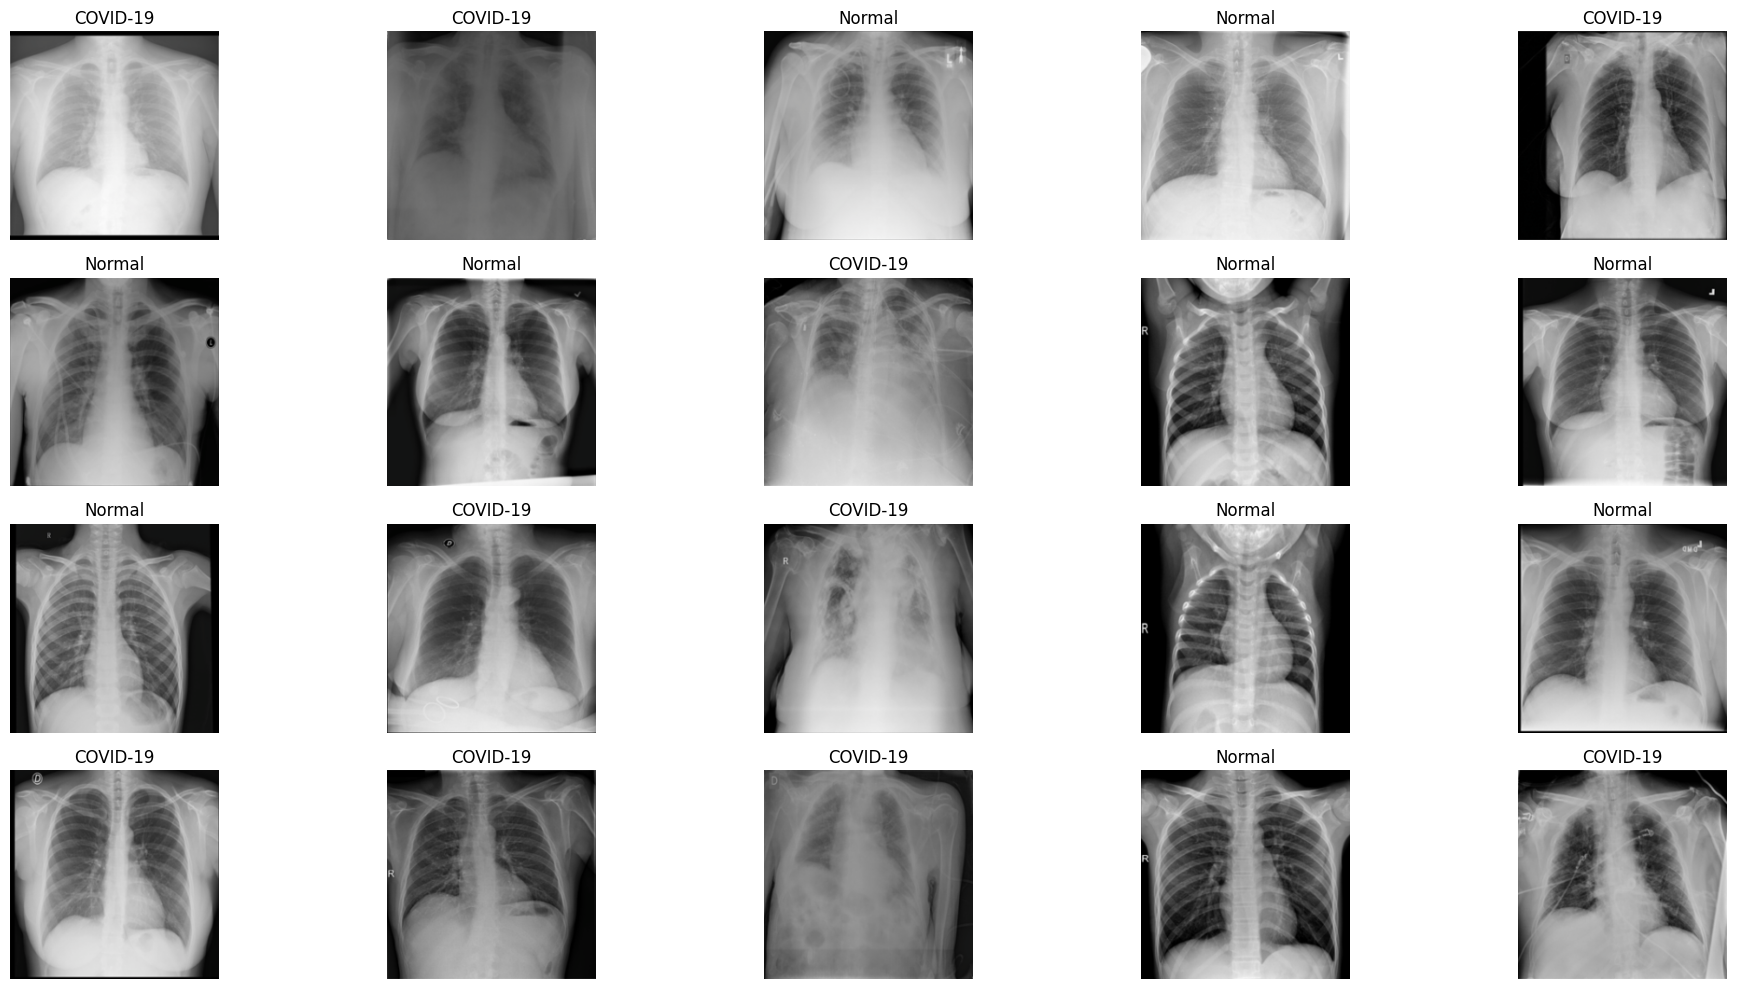

In [11]:
 import matplotlib.pyplot as plt
import torchvision.transforms as T

# Définition d'une fonction d'inversion de la normalisation pour afficher correctement les images
def unnormalize(img):
    # Inverse de Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    inv_normalize = T.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    return inv_normalize(img)

# Nombre d'images à afficher
n_images = 20
plt.figure(figsize=(20, 10))

for i in range(n_images):
    img, label = data_train[i]
    # Unnormalize pour retrouver des couleurs approximatives
    img = unnormalize(img)
    # Convertir le tenseur image en numpy et remettre l'ordre (H, W, C)
    img_np = img.permute(1, 2, 0).numpy()
    # Affichage
    plt.subplot(4, 5, i+1)
    plt.imshow(img_np)
    plt.title("COVID-19" if label.item() == 1 else "Normal")
    plt.axis("off")

plt.tight_layout()
plt.show()


Maintenant qu'on a les datasets avec les images bien dimensionnées pour Deit, créons les dataloader.

In [12]:
print("Number of mini-batches in the training set:", len(train_loader))
print("Number of mini-batches in the training set:", len(val_loader))
print("Number of mini-batches in the testing set:", len(test_loader))

Number of mini-batches in the training set: 227
Number of mini-batches in the training set: 57
Number of mini-batches in the testing set: 71


# Entraînement du modèle Deit sur le dataset

On a modifié le modèle Deit pour avoir 2 classes (tumeur ou non tumeur), et on a créé les dataloaders depuis le dataset COVID. Dans un premier temps, on ne vas toucher qu'à la dernière couche (head) et geler tous les autres paramètres du modèle. Pour cela, on va également définir la fonction precompute qui calcule les images jusqu'à l'entrée de cette couche pour gagner en temps de calcul.

In [13]:
def precompute_deit_tiny_features(model, dataloader):
    model.eval()
    model.to(device)
    list_outputs = []
    list_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            # Utilisation de forward_features pour extraire les représentations intermédiaires
            features = model.forward_features(inputs)
            list_outputs.append(features)
            list_labels.append(labels)

    outputs = torch.cat(list_outputs, dim=0)
    labels = torch.cat(list_labels, dim=0)

    return TensorDataset(outputs, labels)



Pour être certains de ne pas toucher aux autres paramètres, on gèle tous les poids en dehors de la dernière couche.

In [14]:
# Geler tous les paramètres
for param in model_deit.parameters():
    param.requires_grad = False

# Réactiver la mise à jour pour la dernière couche (par exemple, model_deit.head)
for param in model_deit.head.parameters():
    param.requires_grad = True


On va calculer les sorties qui ne changeront pas (avant l'entrée de la tête head) avec la fonction precompute.

In [15]:

torch.cuda.empty_cache()
torch.cuda.ipc_collect()



In [16]:
# Maintenant, vous pouvez pré-calculer les features

precomputed_train_dataset = precompute_deit_tiny_features(model_deit, train_loader)
precomputed_val_dataset = precompute_deit_tiny_features(model_deit, val_loader)
precomputed_test_dataset = precompute_deit_tiny_features(model_deit, test_loader)

precomputed_train_loader = DataLoader(precomputed_train_dataset, batch_size=batch_size, shuffle=True)
precomputed_val_loader = DataLoader(precomputed_val_dataset, batch_size=batch_size, shuffle=True)
precomputed_test_loader = DataLoader(precomputed_test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
features, labels = precomputed_train_dataset[:5]  # Vérifier les 5 premiers
print(f"Taille d'un sample feature : {features.shape}")
print(f"Taille d'un sample label : {labels.shape}")


Taille d'un sample feature : torch.Size([5, 197, 192])
Taille d'un sample label : torch.Size([5])


La tête de classification (head) s'attend à une entrée de shape (batch_size, 192), pas (batch_size, 197, 192).
On doit donc extraire uniquement le token [CLS], qui se trouve en position 0 (features[:, 0, :]), et qui sert à agréger l'information des autres tokens.

In [18]:
for param in model_deit.parameters():
    param.requires_grad = False  # On gèle tout
for param in model_deit.head.parameters():
    param.requires_grad = True  # On entraîne seulement la tête


## Entraînement de la tête sur nos dataloaders

In [19]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
import torch.optim as optim



Epoch 1/10 | Train Loss: 0.3686 | Train Acc: 83.49% | Val Loss: 0.2779 | Val Acc: 88.99% | Val F1: 0.8940
Epoch 2/10 | Train Loss: 0.2589 | Train Acc: 89.09% | Val Loss: 0.2571 | Val Acc: 89.46% | Val F1: 0.8948
Epoch 3/10 | Train Loss: 0.2401 | Train Acc: 90.18% | Val Loss: 0.2425 | Val Acc: 89.68% | Val F1: 0.8981
Epoch 4/10 | Train Loss: 0.2305 | Train Acc: 90.68% | Val Loss: 0.2383 | Val Acc: 89.99% | Val F1: 0.9009
Epoch 5/10 | Train Loss: 0.2250 | Train Acc: 91.00% | Val Loss: 0.2237 | Val Acc: 90.82% | Val F1: 0.9120
Epoch 6/10 | Train Loss: 0.2206 | Train Acc: 91.23% | Val Loss: 0.2232 | Val Acc: 90.57% | Val F1: 0.9081
Epoch 7/10 | Train Loss: 0.2161 | Train Acc: 91.28% | Val Loss: 0.2176 | Val Acc: 90.87% | Val F1: 0.9119
Epoch 8/10 | Train Loss: 0.2137 | Train Acc: 91.36% | Val Loss: 0.2190 | Val Acc: 91.34% | Val F1: 0.9154
Epoch 9/10 | Train Loss: 0.2116 | Train Acc: 91.63% | Val Loss: 0.2168 | Val Acc: 91.31% | Val F1: 0.9156
Epoch 10/10 | Train Loss: 0.2100 | Train Acc: 

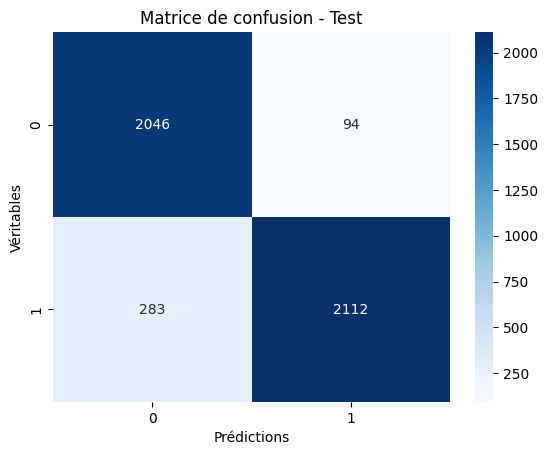

Rapport de classification sur le test:
              precision    recall  f1-score   support

      Normal       0.88      0.96      0.92      2140
    COVID-19       0.96      0.88      0.92      2395

    accuracy                           0.92      4535
   macro avg       0.92      0.92      0.92      4535
weighted avg       0.92      0.92      0.92      4535



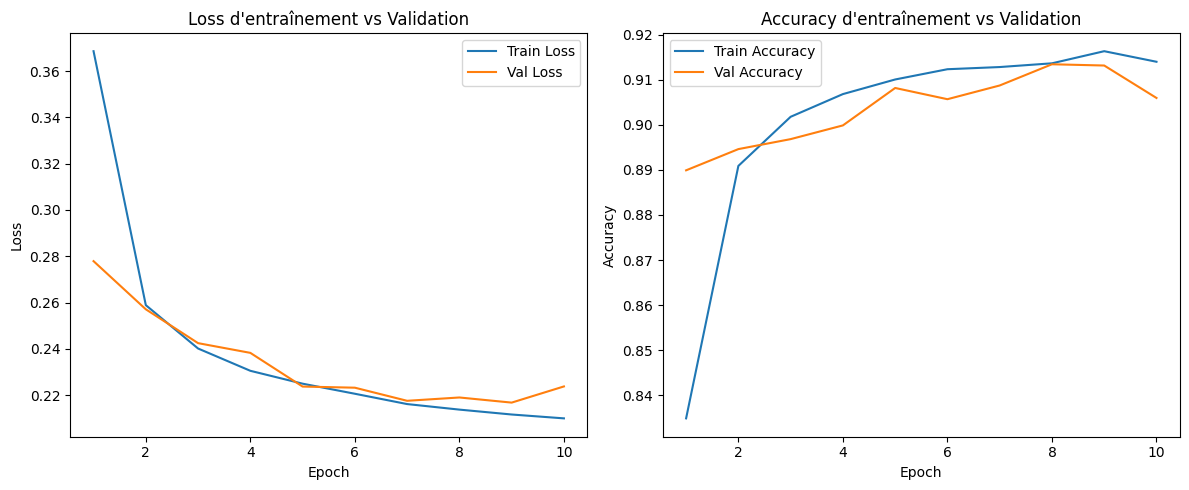

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assurez-vous que votre device est bien défini
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_deit.head.to(device)

# Paramètres d'entraînement
num_epochs = 10         # Nombre d'époques (à ajuster)
learning_rate = 0.001   # Taux d'apprentissage
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_deit.head.parameters(), lr=learning_rate)

# Listes pour suivre les métriques
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_f1_scores = []

# Boucle d'entraînement
for epoch in range(num_epochs):
    # === Entraînement ===
    model_deit.head.train()
    running_loss, correct_preds, total = 0.0, 0, 0

    for features, labels in precomputed_train_loader:
        features, labels = features.to(device), labels.to(device)
        # Sélection du token CLS (première position)
        cls_features = features[:, 0, :]

        optimizer.zero_grad()
        outputs = model_deit.head(cls_features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        preds = torch.argmax(outputs, dim=1)
        correct_preds += torch.sum(preds == labels).item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct_preds / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # === Validation ===
    model_deit.head.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    all_val_preds, all_val_labels = [], []

    with torch.no_grad():
        for features, labels in precomputed_val_loader:
            features, labels = features.to(device), labels.to(device)
            cls_features = features[:, 0, :]
            outputs = model_deit.head(cls_features)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * labels.size(0)
            preds = torch.argmax(outputs, dim=1)
            val_correct += torch.sum(preds == labels).item()
            val_total += labels.size(0)

            all_val_preds.append(preds.cpu())
            all_val_labels.append(labels.cpu())

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Calcul du F1-score sur la validation (moyenne "binary" pour 2 classes)
    all_val_preds = torch.cat(all_val_preds).numpy()
    all_val_labels = torch.cat(all_val_labels).numpy()
    val_f1 = f1_score(all_val_labels, all_val_preds, average="binary")
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%} | Val F1: {val_f1:.4f}")

print("✅ Entraînement terminé !")

# === Évaluation finale sur l'ensemble de test ===
model_deit.head.eval()
all_test_preds, all_test_labels = [], []

with torch.no_grad():
    for features, labels in precomputed_test_loader:
        features, labels = features.to(device), labels.to(device)
        cls_features = features[:, 0, :]
        outputs = model_deit.head(cls_features)
        preds = torch.argmax(outputs, dim=1)
        all_test_preds.append(preds.cpu())
        all_test_labels.append(labels.cpu())

all_test_preds = torch.cat(all_test_preds).numpy()
all_test_labels = torch.cat(all_test_labels).numpy()

# Affichage de la matrice de confusion
cm = confusion_matrix(all_test_labels, all_test_preds)
print("Matrice de confusion sur le test:")
print(cm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion - Test")
plt.xlabel("Prédictions")
plt.ylabel("Véritables")
plt.show()

# Affichage du rapport de classification
print("Rapport de classification sur le test:")
print(classification_report(all_test_labels, all_test_preds, target_names=["Normal", "COVID-19"]))

# === Affichage des courbes d'évolution ===
epochs = range(1, num_epochs+1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss d'entraînement vs Validation")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy d'entraînement vs Validation")
plt.legend()

plt.tight_layout()
plt.show()


In [24]:
## Sauvegarder les poids de la dernière couche

from google.colab import drive
drive.mount('/content/drive')

# Définissez le chemin où vous voulez sauvegarder dans Google Drive, par exemple dans MyDrive
save_path = '/content/drive/MyDrive/deit_tiny_head_weights.pth'

# Sauvegarder les poids de la tête de votre modèle
torch.save(model_deit.head.state_dict(), save_path)
print("Poids sauvegardés dans :", save_path)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Poids sauvegardés dans : /content/drive/MyDrive/deit_tiny_head_weights.pth
